# LightGBM

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [12]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix

### Importing data

In [5]:
data_path = "../../data/"
label_col = "Label"

train_data = pd.read_csv(data_path + "train.csv")
test_data = pd.read_csv(data_path + "test.csv")

drop_cols = [
    "time",
    "SNo"
]

X = train_data.drop(drop_cols + ["Label"], axis=1).copy()
y = train_data[label_col].copy()

In [16]:
pd.read_csv(data_path + "train.csv")["Label"].value_counts(normalize=True)

0    0.785947
2    0.173280
1    0.040773
Name: Label, dtype: float64

### Cross validation setup and data split

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-folds as an example, adjust as necessary

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_train = pd.DataFrame(X_train, columns=X.columns)

### Train lightgbm

In [9]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [14]:
model_lgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
model_lgbm.fit(train_data.data, y=train_data.get_label())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8476
[LightGBM] [Info] Number of data points in the train set: 29989, number of used features: 35
[LightGBM] [Info] Start training from score -0.241705
[LightGBM] [Info] Start training from score -3.180090
[LightGBM] [Info] Start training from score -1.753712


LGBMClassifier(n_jobs=-1, random_state=123)

## Evaluating model

In [15]:
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

In [16]:
accuracy_score(y_valid_pred, valid_data.get_label())

0.8918150429896419

Submission: 0.777

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

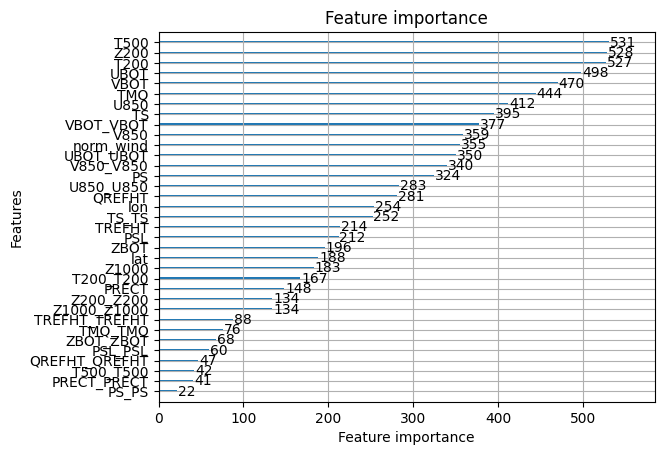

In [17]:
lgb.plot_importance(model_lgbm)

### Using model to predict test data

In [15]:
test_data_sel = test_data.drop(drop_cols, axis=1)
test_data_sel = scaler.fit_transform(test_data_sel)

test_data['Label'] = model_lgbm.predict(test_data_sel)

submission = test_data[["SNo", "Label"]].copy()

In [18]:
submission.to_csv(f"predictions_lightgbm_{datetime.now()}.csv", index=False)